In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn

In [13]:
torch.manual_seed(42)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


In [14]:
def function_1(x):
  return (np.sin(5 * (np.pi) * x)) / (5 * np.pi * x)

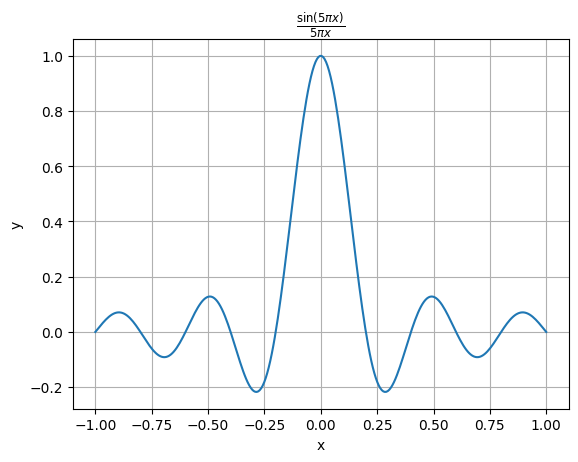

In [15]:
# Generate Data for fun 1
x = np.linspace(-1, 1, 300).reshape(-1, 1)
y = function_1(x)
func1_x, func1_y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
plt.plot(func1_x, func1_y)
plt.title(r'$\frac{\sin(5 \pi x)}{5 \pi x}$')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()


In [16]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer_1 = nn.Linear(1, 5)
        self.layer_2 = nn.Linear(5, 10)
        self.layer_3 = nn.Linear(10, 10)
        self.layer_4 = nn.Linear(10, 10)
        self.layer_5 = nn.Linear(10, 10)
        self.layer_6 = nn.Linear(10, 10)
        self.layer_7 = nn.Linear(10, 5)
        self.layer_8 = nn.Linear(5, 1)

    def forward(self, input_data):
        x1 = F.relu(self.layer_1(input_data))
        x2 = F.relu(self.layer_2(x1))
        x3 = F.relu(self.layer_3(x2))
        x4 = F.relu(self.layer_4(x3))
        x5 = F.relu(self.layer_5(x4))
        x6 = F.relu(self.layer_6(x5))
        x7 = F.relu(self.layer_7(x6))
        x8 = self.layer_8(x7)
        return x8

In [17]:
model = Model()
total_params = sum(p.numel() for p in model.parameters())
print('Total params - ', total_params)

Total params -  571


In [24]:
def train_model(model, inputs, outputs):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
    max_epochs = 5000
    losses = []
    grad_data = []

    for epoch in range(max_epochs):
        model.train()
        predictions = model(inputs)
        loss = criterion(predictions, outputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        grad_all = 0.0
        for p in model.parameters():
            grad = 0.0
            if p.grad is not None:
                grad = (p.grad.cpu().data.numpy()**2).sum()
            grad_all += grad
        grad_norm = grad_all ** 0.5
        grad_data.append(grad_norm)

        if grad_norm < 0.001 or epoch == max_epochs-1:
            print('Gradient norm reached minimum value')

            # Calculate minimal ratio and loss
            minimal_ratio, loss_val = calculate_hessian(model, inputs, outputs)
            print(f"epoch - {epoch} Minimal Ratio - {minimal_ratio}  Loss - {loss_val}")
            break

    return minimal_ratio, loss_val

In [27]:
def calculate_hessian(model, x, y):
    criterion = nn.MSELoss()
    total_params = sum(p.numel() for p in model.parameters())

    predictions = model(x)
    loss = criterion(predictions, y)

    # Calculate gradients of the loss with respect to the model parameters
    Jacob = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    Jacob_flat = torch.cat([e.flatten() for e in Jacob])

    H = torch.zeros((total_params, total_params))

    # Calculate the second-order derivatives (Hessian matrix)
    for i in range(total_params):
        result = torch.autograd.grad(Jacob_flat[i], model.parameters(), retain_graph=True)
        H[i] = torch.cat([r.flatten() for r in result])

    # Compute eigenvalues of the Hessian matrix
    H_eigenvalues = torch.linalg.eig(H).eigenvalues.real

    positive_count = (H_eigenvalues > 0).sum().item()

    minimal_ratio = positive_count / total_params

    return minimal_ratio, loss.item()

In [28]:
loss_arr = []
min_ratio_arr = []
for index in range(100):
    print("Training model ", index)
    model = Model()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

    min_ratio, loss_value = train_model(model, func1_x, func1_x)
    loss_arr.append(loss_value)
    min_ratio_arr.append(min_ratio)

Training model  0
Gradient norm reached minimum value
epoch - 2784 Minimal Ratio - 0.2329246935201401  Loss - 7.053658464428736e-06
Training model  1
Gradient norm reached minimum value
epoch - 4999 Minimal Ratio - 0.2539404553415061  Loss - 0.00689693121239543
Training model  2
Gradient norm reached minimum value
epoch - 4999 Minimal Ratio - 0.15586690017513136  Loss - 0.03902234137058258
Training model  3
Gradient norm reached minimum value
epoch - 4999 Minimal Ratio - 0.19614711033274956  Loss - 0.02085527777671814
Training model  4
Gradient norm reached minimum value
epoch - 4999 Minimal Ratio - 0.2714535901926445  Loss - 0.11784771084785461
Training model  5
Gradient norm reached minimum value
epoch - 4999 Minimal Ratio - 0.18213660245183888  Loss - 0.15559729933738708
Training model  6
Gradient norm reached minimum value
epoch - 2693 Minimal Ratio - 0.014010507880910683  Loss - 0.33556312322616577
Training model  7
Gradient norm reached minimum value
epoch - 3256 Minimal Ratio - 

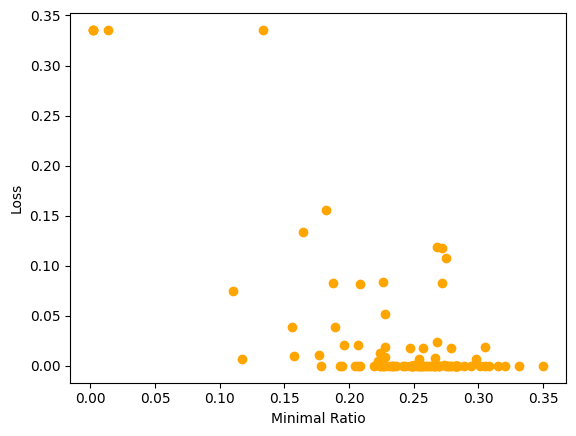

In [29]:
plt.scatter(min_ratio_arr,loss_arr, color = "orange")
plt.xlabel("Minimal Ratio")
plt.ylabel("Loss")
plt.show()